<a href="https://colab.research.google.com/github/ftp1/deeplearning/blob/master/oneshotlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(60000, 28, 28, 1)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 4)         104       
_________________________________________________________________
average_pooling2d_4 (Average (None, 12, 12, 4)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 16)          1616      
_________________________________________________________________
average_pooling2d_5 (Average (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10) 

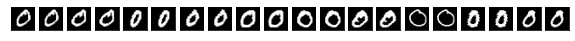

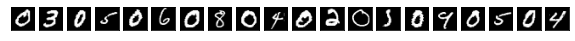

[0.2941413]
[0.95263225]
[0.24266507]
[1.4957451]
[0.1041914]
[1.3686442]
[0.34248275]
[0.9003318]
[0.21177329]
[1.4194602]
[0.1338765]
[1.4562072]
[0.10034366]
[1.4595628]
[0.09788977]
[1.3586463]
[0.11742967]
[1.0938973]
[0.1738694]
[1.1822147]


In [3]:
# -*- coding: utf-8 -*-
"""siamese_mnist.ipynb
"""



from __future__ import absolute_import
from __future__ import print_function
import keras
import numpy as np
import tensorflow as tf

import random
from keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Activation,AveragePooling2D
from tensorflow.keras.optimizers import RMSprop

from keras import backend as K

num_classes = 10
epochs = 20

def euclid_dis(vects):
  x,y = vects

  sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
  #y=tf.cast(y,tf.int64)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def create_pairs(x, digit_indices):
  pairs = []
  labels = []

  n=min([len(digit_indices[d]) for d in range(num_classes)]) -1

  for d in range(num_classes):
    for i in range(n):
      z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
      pairs += [[x[z1], x[z2]]]
      inc = random.randrange(1, num_classes)
      dn = (d + inc) % num_classes
      z1, z2 = digit_indices[d][i], digit_indices[dn][i]
      pairs += [[x[z1], x[z2]]]
      labels += [1,0]
  return np.array(pairs), np.array(labels)


def create_base_net(input_shape):

  input = Input(shape = input_shape)
  x = Conv2D(4, (5,5), activation = 'tanh')(input)
  x = AveragePooling2D(pool_size = (2,2))(x)
  x = Conv2D(16, (5,5), activation = 'tanh')(x)
  x = AveragePooling2D(pool_size = (2,2))(x)
  x = Flatten()(x)
  x = Dense(10, activation = 'tanh')(x)
  model = Model(input, x)
  model.summary()

  return model

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
# input_shape = (1, 28, 28)
print(x_train.shape)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

input_shape = x_train.shape[1:]
input_shape = (28, 28, 1)
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)



# network definition
base_network = create_base_net(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclid_dis,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

import matplotlib.pyplot as plt
from PIL import Image
number_of_items = 20


# print(tr_pairs[1,0].shape)
# tr_pairs[1,0] = tr_pairs[1,0].reshape(28, 28)

im = tf.keras.preprocessing.image.array_to_img(
    tr_pairs[1,0],
    data_format=None,
    scale=True,
    dtype=None
)

plt.figure(figsize=(10, 5))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( tr_pairs[item,0], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(10, 5))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( tr_pairs[item,1], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()

for i in range(number_of_items):
  print(y_pred[i])
# plt.figure(figsize=(20, 2))
# plt.imshow(im, cmap="gray")
# plt.show()